In [82]:
%pip install -r '../requirements.txt'


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [83]:
import shutil
import os
import zipfile


dependency_path = '../dependencies/'
file_name = 'archive.zip'
file_id = '1PWh1rMqWh0JjkygP-CZbYn-VtL2TMrmB'
files_to_check = ['reviews_0-250.csv', 'reviews_250-500.csv', 'reviews_500-750.csv', 'reviews_750-1250.csv', 'reviews_1250-end.csv']


def download_file(id_of_file, destination):
    os.system('gdown ' + id_of_file + ' -O ' + destination)

def check_files():
    if not os.path.exists(dependency_path):
        return False
    for file_to_check in files_to_check:
        if not os.path.exists(os.path.join(dependency_path, file_to_check)):
            return False
    return True

if not check_files():
    if os.path.exists(dependency_path):
        shutil.rmtree(dependency_path)
    os.makedirs(dependency_path) 
    download_file(file_id, dependency_path + file_name)
    try:
        with zipfile.ZipFile(dependency_path + file_name, 'r') as zip_ref:
            zip_ref.extractall(dependency_path)
        print("Extraction successful.")
        os.remove(dependency_path + file_name)
    except zipfile.BadZipFile:
        print("Error while extracting zip")
    if os.path.exists(dependency_path + '__MACOSX'):
        shutil.rmtree(dependency_path + '__MACOSX')
    for file in files_to_check:
        shutil.move(dependency_path + 'archive/' + file, dependency_path + file)
    shutil.rmtree(dependency_path + 'archive')
else:
    print("Files already exist, skipping download")
    

Files already exist, skipping download


In [84]:
import requests
from bs4 import BeautifulSoup

if not os.path.exists('../data/brand_links.txt'):
    brand_lst_link = 'https://sephora.com/brands-list'
    response = requests.get(url=brand_lst_link, headers={'User-Agent': 'Your Custom User-Agent'})
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Scraping brand links and saving them into a list
    brand_link_lst = []
    main_box = soup.find_all(attrs={"data-at": "brand_link", "data-comp": "StyledComponent BaseComponent "})
    
    for brand in main_box:
        brand_link = brand.get('href')
        if not str(brand_link).startswith('/brand'):
            brand_link = '/brand' + brand_link
        brand_link_lst.append("https://www.sephora.com" + brand_link + "/all?pageSize=300")
    
    if not os.path.exists('../data/'):
        os.mkdir('../data/')
    with open('../data/brand_links.txt', 'w') as f:
        for link in brand_link_lst:
            f.write(link + '\n')
            
    print("Saving brand links to /data/brand_links.txt")
    
else:
    print("Extracted brand links found at /data/brand_links.txt, proceeding with locally saved file. To re-extract the brand links, delete the file and run the cell again")


Extracted brand links found at /data/brand_links.txt, proceeding with locally saved file. To re-extract the brand links, delete the file and run the cell again


In [85]:
import json
import pandas as pd


brand_links = []
with open('../data/brand_links.txt', 'r') as f:
    for line in f:
        brand_links.append(line.strip())

if not os.path.exists('../data/product_links.csv'):
    print("Brand links have been loaded from the text file: brand_links.txt")
    
    brand_names = []
    product_names = []
    product_ids = []
    product_links = []
    
    for brand in brand_links:
        brand_name = brand.split("/")[4]
        print("Scraping data for " + brand_name)
        response = requests.get(url=brand, headers={'User-Agent': 'Your Custom User-Agent'})
        soup = BeautifulSoup(response.content, 'html.parser')
        try:
            products = soup.find(attrs={"data-comp": "PageJSON "})
            products = json.loads(products.get_text('script')).get('page').get('nthBrand').get('products')
            for product in products:
                mini_url = product.get('targetUrl')
                product_name = product.get('displayName')
                product_id = product.get('productId')
                product_link = "https://www.sephora.com" + mini_url + "/all?pageSize=300"
    
                brand_names.append(brand_name)
                product_names.append(product_name)
                product_ids.append(product_id)
                product_links.append(product_link)
        except TypeError as e:
            print("No products found for the Brand: " + brand_name)
    
    products_df = pd.DataFrame({
        'brand_name': brand_names,
        'product_name': product_names,
        'product_id': product_ids,
        'product_link': product_links
    })
    products_df.to_csv("../data/product_links.csv")
    print("Saving product links to /data/product_links.csv")
    
else:
    products_df = pd.read_csv('../data/product_links.csv')
    brand_names = products_df['brand_name'].tolist()
    product_names = products_df['product_name'].tolist()
    product_ids = products_df['product_id'].tolist()
    product_links = products_df['product_link'].tolist()
    print("Extracted product links found at /data/product_links.csv, proceeding with locally saved file. To re-extract the product links, delete the file and run the cell again")


Extracted product links found at /data/product_links.csv, proceeding with locally saved file. To re-extract the product links, delete the file and run the cell again


In [86]:
reviews = []
for file in files_to_check:
    reviews.append(pd.read_csv(dependency_path + file, low_memory=False))
reviews_df = pd.concat(reviews, ignore_index=True)

In [87]:
reviews_df.head()

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


In [88]:
reviews_df.describe()

,Unnamed: 0,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,price_usd
count,1.094411e+06,1.094411e+06,926423.000000,532819.000000,1.094411e+06,1.094411e+06,1.094411e+06,1.094411e+06
mean,1.989864e+05,4.299158e+00,0.839962,0.767782,4.177126e+00,8.948695e-01,3.282257e+00,4.900838e+01
std,1.749886e+05,1.149444e+00,0.366642,0.317164,2.271524e+01,5.288943e+00,1.967482e+01,4.004338e+01
min,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,5.590600e+04,4.000000e+00,1.000000,0.652174,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+01
50%,1.308240e+05,5.000000e+00,1.000000,0.928571,0.000000e+00,0.000000e+00,0.000000e+00,3.900000e+01
75%,3.285265e+05,5.000000e+00,1.000000,1.000000,3.000000e+00,1.000000e+00,3.000000e+00,6.200000e+01
max,6.021290e+05,5.000000e+00,1.000000,1.000000,5.464000e+03,1.159000e+03,5.050000e+03,1.900000e+03


In [89]:
product_id_list = reviews_df['product_id'].unique()

In [90]:
len(product_id_list)

2351

In [91]:
common_products = []
for product in product_ids:
    for product_idx in product_id_list:
        if product == product_idx:
            common_products.append(product)
print("There are " +str(len(common_products)) + " common products")

There are 1593 common products


In [92]:
reviews_df = reviews_df[reviews_df['product_id'].isin(common_products)]

In [93]:
len(reviews_df['product_id'].unique())

1593

In [94]:
products_df = products_df[products_df['product_id'].isin(common_products)]

In [95]:
products_df.count()

Unnamed: 0      1593
brand_name      1593
product_name    1593
product_id      1593
product_link    1593
dtype: int64

In [96]:
import time
import json
import re


def remove_text_in_parentheses(input_string):
    result = re.sub(r'\([^)]*\)', '', input_string)
    return result.strip()

def get_chemicals_from_link(product_link):
    response = requests.get(url=product_link, headers={'User-Agent': 'User-Agent'})
    soup = BeautifulSoup(response.content, 'html.parser')
    product = soup.find(attrs={"data-comp": "PageJSON "})
    try:
        ingredients_text = json.loads(product.get_text('script')).get('page').get('product').get('currentSku').get(
            'ingredientDesc')
    except Exception as e:
        return []
    if not ingredients_text:
        return []
    ingredients_soup = BeautifulSoup(ingredients_text, 'html.parser')
    names = ingredients_soup.get_text().split(',')
    individual_names = [name for name in names if name.strip()]

    cleaned_names = []
    for name in individual_names:
        if name.startswith('*'):
            continue
        if len(name) < 4:
            continue
        cleaned_name = remove_text_in_parentheses(name)
        if cleaned_name and not cleaned_name.endswith('*'):
            cleaned_names.append(cleaned_name)
            
    ingredients = list(set(cleaned_names))
    chemicals = []

    for ingredient in ingredients:
        retries = 2  # Number of retries
        while retries > 0:
            response = requests.get("https://webbook.nist.gov/cgi/cbook.cgi?Name=" + ingredient + "&Units=SI")
            if response.status_code == 200:
                soup = BeautifulSoup(response.content, 'html.parser')
                title = soup.find('title').get_text()
                if title == "Search Results":
                    best_match = soup.find('main').find('ol').find('li').find('a').get_text()
                    chemicals.append(best_match)
                elif title == "Name Not Found":
                    break
                elif title == "No Matching Species Found":
                    break
                else:
                    chemicals.append(title)
                break 
            else:
                time.sleep(5)
                retries -= 1
        else:
            print(f"Error: Unable to fetch data for ingredient {ingredient}")
    
    return chemicals


if not os.path.exists('../data/products.csv'):
    print("Product links has been loaded from the file: product_links.csv")
    chemicals_lists = []
    total_products = len(products_df)
    
    for i, (index, row) in enumerate(products_df.iterrows(), start=1):
        product_link = row['product_link']
        product_name = row['product_name']
        chemicals = get_chemicals_from_link(product_link)
        chemicals_lists.append(chemicals)
        if chemicals:
            print(f"Chemicals extracted for {i}/{total_products} products: {product_name}")   
            print(chemicals)
        else:
            print("No chemicals found for " + product_name)
    
    products_df['chemicals_list'] = chemicals_lists
    products_df.to_csv("../data/products.csv")
    print("Saving chemicals in products to /data/products.csv")
else:
    products_df = pd.read_csv("../data/products.csv")
    print("Extracted chemicals in products found at /data/products.csv, proceeding with locally saved file. To re-extract the product links, delete the file and run the cell again")

Extracted chemicals in products found at /data/products.csv, proceeding with locally saved file. To re-extract the product links, delete the file and run the cell again


In [97]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      1498 non-null   int64 
 1   brand_name      1498 non-null   object
 2   product_name    1498 non-null   object
 3   product_id      1498 non-null   object
 4   product_link    1498 non-null   object
 5   chemicals_list  1498 non-null   object
dtypes: int64(1), object(5)
memory usage: 70.3+ KB


In [98]:
products_df = products_df[["brand_name", "product_name", "product_id", "product_link", "chemicals_list"]]

In [99]:
products_df.count()

brand_name        1498
product_name      1498
product_id        1498
product_link      1498
chemicals_list    1498
dtype: int64

In [100]:
products_df = products_df[products_df['chemicals_list'].apply(lambda x: len(eval(x)) > 0)]

In [101]:
products_df.count()

brand_name        1498
product_name      1498
product_id        1498
product_link      1498
chemicals_list    1498
dtype: int64

In [102]:
from collections import Counter
import ast


common_chemicals_list = []

for chemicals_list in products_df['chemicals_list']:
    common_chemicals_list.extend(ast.literal_eval(chemicals_list))

chemicals_frequency = dict(Counter(common_chemicals_list).most_common())

print("Total unique chemicals:", len(chemicals_frequency.keys()))

high_frequency_chemicals_list = []
for chemical in chemicals_frequency.keys():
    if chemicals_frequency[chemical] > 15:
        high_frequency_chemicals_list.append(chemical)


Total unique chemicals: 406


In [103]:
print("Chemicals that occur in more than 15 products: ")
for high_frequency_chemical in high_frequency_chemicals_list:
    print(high_frequency_chemical)
print("Total High Frequency chemicals: ", len(high_frequency_chemicals_list))

Chemicals that occur in more than 15 products: 
Glycerin
Propylene Glycol
1,3-Butanediol
Ethanol, 2-phenoxy-
Vitamin E
Citric acid
Sodium hydroxide
sodium benzoate
α-Tocopheryl acetate
1,5-Pentanediol
Squalane
Siloxanes and Silicones, di-Me
Limonene
Linalool
Niacinamide
Lecithin
Dioxosilane
Lactic acid
sodium chloride
Citronellol
1-Hexadecanol
Caffeine
2,6-Octadien-1-ol, 3,7-dimethyl-, (E)-
Betaine
Octadecanoic acid
Chlorphenesin carbamate
Allantoin
Ethanol
Water
9-α-d-Arabinofuranosyladenine
Trehalose
Hexylene glycol
Benzyl alcohol
2,6-Octadienal, 3,7-dimethyl-
Mica
Behenic alcohol
Titanium dioxide (anatase)
Salicylic acid
α-Bisabolol
Butylated Hydroxytoluene
Arginine
Acetic acid, hydroxy-
Vitamin C
9,12-Octadecadienoic acid (Z,Z)-
Potassium hydroxide
2-Propanol, 1,1'-oxybis-
Sorbitol
n-Hexadecanoic acid
Sodium hydrogen sulfite
D-Gluconic acid, δ-lactone
Tromethamine
Cholesterol
Sucrose
Urea
1-Octadecanol
Glucose
Phenylethyl Alcohol
Retinol
Kaolin
1-Dodecanol, 2-octyl-
Dehydroacetic A

In [104]:
from ast import literal_eval


products_df['chemicals_list'] = products_df['chemicals_list'].apply(literal_eval)

chemical_counts = pd.Series([chemical for sublist in products_df['chemicals_list'] for chemical in sublist]).value_counts()

frequent_chemicals = chemical_counts[chemical_counts > 15].index.tolist()
filtered_chemicals_list = products_df['chemicals_list'].apply(lambda x: [chemical for chemical in x if chemical in frequent_chemicals]).tolist()

products_df['filtered_chemicals'] = filtered_chemicals_list

print(filtered_chemicals_list)

filtered_products_df = products_df[["brand_name", "product_name", "product_id", "filtered_chemicals"]]
filtered_products_df.to_csv('../data/filtered_products.csv', index=False)


[['Benzyl Benzoate', 'α-Tocopheryl acetate', 'Water', 'Ethanol, 2-phenoxy-', 'Glycerin', 'Chlorphenesin carbamate', 'Vitamin A palmitate'], ['1,5-Pentanediol', '9-α-d-Arabinofuranosyladenine', 'Niacinamide', 'Sodium hydroxide', 'Ethanol, 2-phenoxy-', 'Glycerin', 'n-Hexadecanoic acid', '1,3-Butanediol', 'Propylene Glycol', 'Vitamin E', 'Limonene', 'Betaine'], ['Citric acid', 'Phenylethyl Alcohol', 'Siloxanes and Silicones, di-Me', 'Triethyl citrate', 'Ethanol, 2-phenoxy-', 'Glycerin', 'Vitamin E', 'Hexylene glycol', 'Lecithin', 'Sodium hydroxide'], ['1,5-Pentanediol', '9-α-d-Arabinofuranosyladenine', 'Benzyl Benzoate', 'Ethanol, 2-phenoxy-', 'Glycerin', 'sodium benzoate', 'n-Hexadecanoic acid', 'Sorbic Acid', 'Propylene Glycol', 'Vitamin E', 'Sodium hydroxide'], ['Octadecanoic acid', 'Citric acid', '1,5-Pentanediol', 'Chrysin', 'Siloxanes and Silicones, di-Me', 'Sodium hydroxide', 'Glycerin', 'sodium benzoate', 'Chlorphenesin carbamate', '1,3-Butanediol', 'Dioxosilane', '1-Hexadecanol']

In [105]:

unique_chemicals = set(chem for sublist in filtered_products_df['filtered_chemicals'] for chem in sublist)

for chemical in unique_chemicals:
    filtered_products_df[chemical] = 0

for index, row in filtered_products_df.iterrows():
    chemicals = row['filtered_chemicals']
    for chem in chemicals:
        filtered_products_df.at[index, chem] = 1


/var/folders/cs/rh0jmwf17rj23jjxx0b7rn5m0000gn/T/ipykernel_59975/121626811.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_products_df[chemical] = 0
/var/folders/cs/rh0jmwf17rj23jjxx0b7rn5m0000gn/T/ipykernel_59975/121626811.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  filtered_products_df[chemical] = 0
/var/folders/cs/rh0jmwf17rj23jjxx0b7rn5m0000gn/T/ipykernel_59975/121626811.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 

In [106]:
filtered_products_df.head()

,brand_name,product_name,product_id,filtered_chemicals,"1,3-Butanediol",Glycerin,Myristyl myristate,Propylene Glycol,Dodecanoic acid,β Carotene,...,Sorbitol,Methylparaben,Tromethamine,Niacinamide,"9,12,15-Octadecatrienoic acid, (Z,Z,Z)-",Sodium hydroxide,Eugenol,Arginine,Dehydroacetic Acid,Isoamyl laurate
0,algenist,GENIUS Ultimate Anti-Aging Melting Cleanser,P388200,"[Benzyl Benzoate, α-Tocopheryl acetate, Water,...",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,algenist,GENIUS Liquid Collagen® Serum,P421277,"[1,5-Pentanediol, 9-α-d-Arabinofuranosyladenin...",1,1,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
2,algenist,GENIUS Sleeping Collagen Moisturizer,P439055,"[Citric acid, Phenylethyl Alcohol, Siloxanes a...",0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,algenist,GENIUS Liquid Collagen Lip Treatment,P432045,"[1,5-Pentanediol, 9-α-d-Arabinofuranosyladenin...",0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,algenist,GENIUS Ultimate Anti-Aging Eye Cream,P388262,"[Octadecanoic acid, Citric acid, 1,5-Pentanedi...",1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [107]:
encoded_df = filtered_products_df.drop(columns=["brand_name", "product_name", "filtered_chemicals"], axis=1)

In [108]:
encoded_df.head()

,product_id,"1,3-Butanediol",Glycerin,Myristyl myristate,Propylene Glycol,Dodecanoic acid,β Carotene,Threonine,"Acetic acid, hydroxy-",N-Acetyl-D-glucosamine,...,Sorbitol,Methylparaben,Tromethamine,Niacinamide,"9,12,15-Octadecatrienoic acid, (Z,Z,Z)-",Sodium hydroxide,Eugenol,Arginine,Dehydroacetic Acid,Isoamyl laurate
0,P388200,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,P421277,1,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,P439055,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,P432045,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,P388262,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [109]:
encoded_df.to_csv("../data/encoded_chemicals.csv")

In [110]:
products_with_chemicals = encoded_df["product_id"].tolist()

reviews_df = reviews_df[reviews_df['product_id'].isin(products_with_chemicals)]

print("Total unique products in reviews after dropping non common products", len(reviews_df['product_id'].unique()))

reviews_df['review_title'] = reviews_df['review_title'].fillna('').astype(str)
reviews_df['review_text'] = reviews_df['review_text'].fillna('').astype(str)

sentiment_df = pd.DataFrame()
sentiment_df['full_review'] = reviews_df['review_title'] + ": " + reviews_df['review_text']
sentiment_df['product_id'] = reviews_df['product_id']

Total unique products in reviews after dropping non common products 1498


In [111]:
sentiment_df.head()

,full_review,product_id
0,Taught me how to double cleanse!: I use this w...,P504322
1,Disappointed: I bought this lip mask after rea...,P420652
2,New Favorite Routine: My review title says it ...,P420652
3,Can't go wrong with any of them: I’ve always l...,P420652
4,"A must have !!!: If you have dry cracked lips,...",P420652


In [112]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return sia.polarity_scores(text)['compound']


sentiment_df['sentiment_score'] = sentiment_df['full_review'].apply(get_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rohithmullapudi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [113]:
sentiment_df.head()

,full_review,product_id,sentiment_score
0,Taught me how to double cleanse!: I use this w...,P504322,0.9421
1,Disappointed: I bought this lip mask after rea...,P420652,-0.3818
2,New Favorite Routine: My review title says it ...,P420652,0.2732
3,Can't go wrong with any of them: I’ve always l...,P420652,0.9575
4,"A must have !!!: If you have dry cracked lips,...",P420652,0.4983


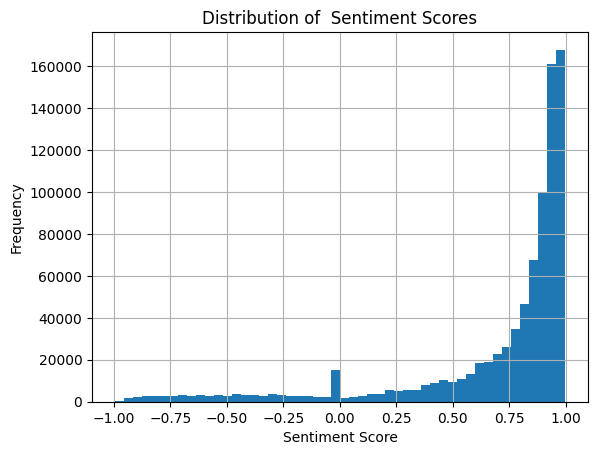

In [114]:
import matplotlib.pyplot as plt

# Histogram of weighted sentiment scores
sentiment_df['sentiment_score'].hist(bins=50)
plt.title('Distribution of  Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

sentiment_df = sentiment_df.groupby('product_id')['sentiment_score'].mean().reset_index()
sentiment_df.columns = ['product_id', 'average_sentiment']

encoded_df = encoded_df.merge(sentiment_df, on='product_id', how='left')

In [115]:
encoded_df.head()

,product_id,"1,3-Butanediol",Glycerin,Myristyl myristate,Propylene Glycol,Dodecanoic acid,β Carotene,Threonine,"Acetic acid, hydroxy-",N-Acetyl-D-glucosamine,...,Methylparaben,Tromethamine,Niacinamide,"9,12,15-Octadecatrienoic acid, (Z,Z,Z)-",Sodium hydroxide,Eugenol,Arginine,Dehydroacetic Acid,Isoamyl laurate,average_sentiment
0,P388200,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.683024
1,P421277,1,1,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0.599415
2,P439055,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.804709
3,P432045,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.510451
4,P388262,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.566315


In [116]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


X = encoded_df.drop(['product_id', 'average_sentiment'], axis=1)
y = encoded_df['average_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Linear Regression Mean Squared Error:", mse)

Linear Regression Mean Squared Error: 0.021952914842862516


In [117]:
from sklearn.ensemble import RandomForestRegressor


rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)


y_pred_rf = rf_model.predict(X_test)


mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Random Forest Mean Squared Error:", mse_rf)

Random Forest Mean Squared Error: 0.019951633733855077


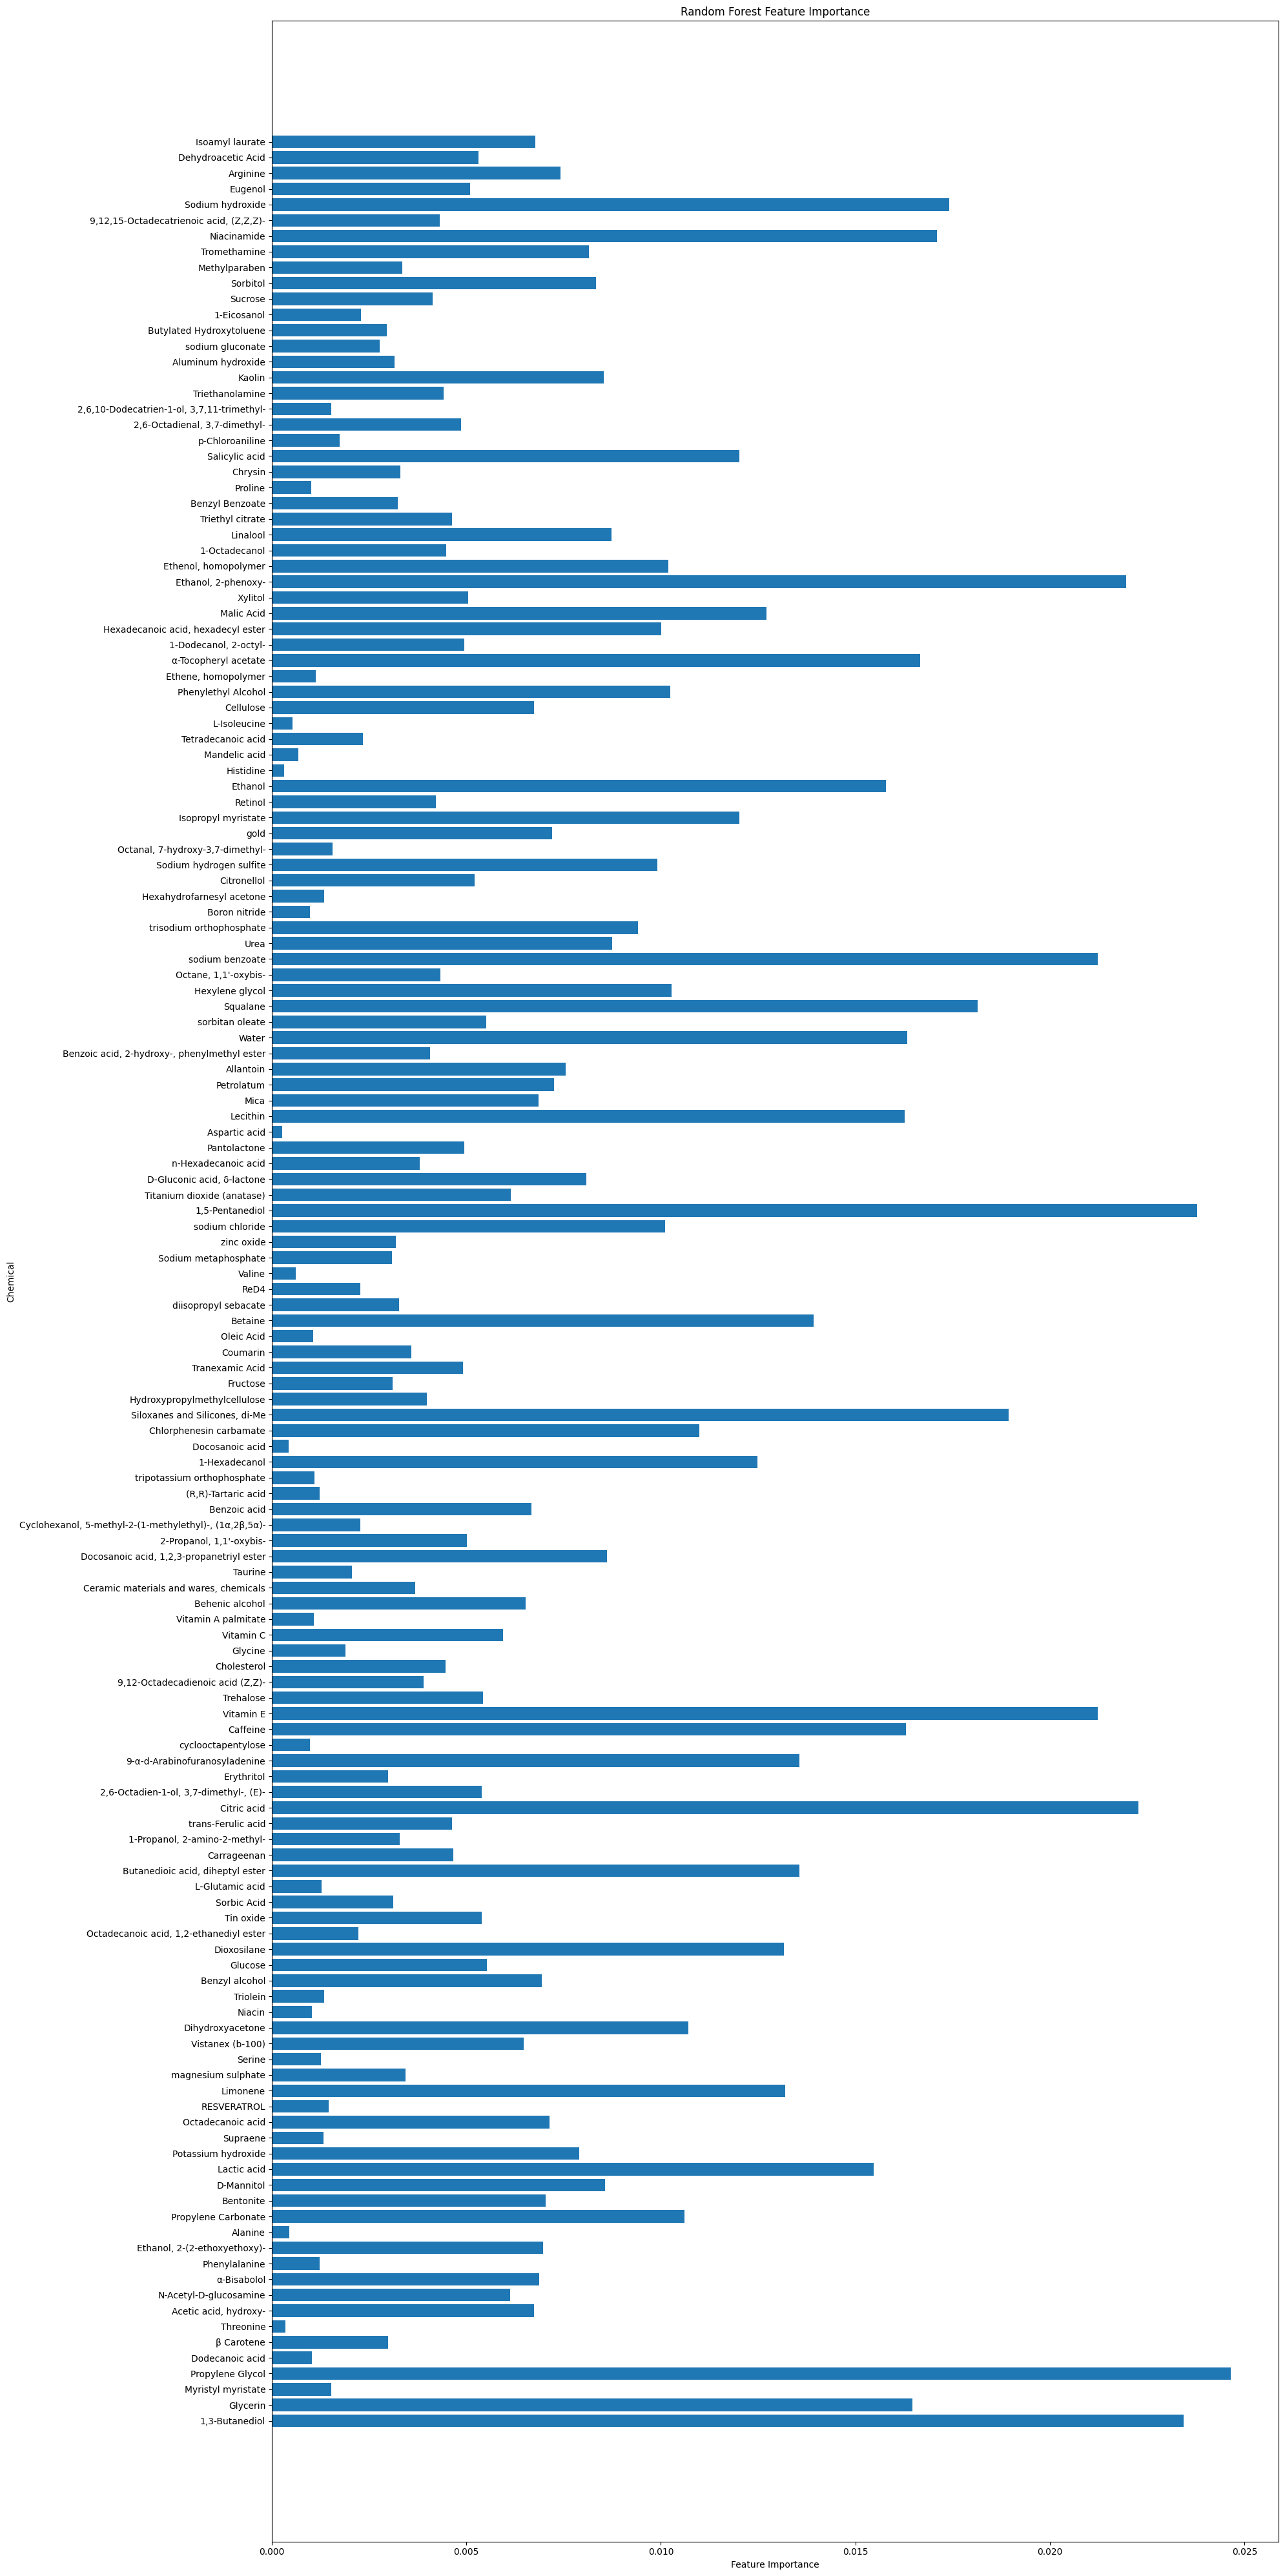

In [118]:
rf_model.fit(X, y)

rf_feature_importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(20, 40))  # Adjust figure size as needed
plt.barh(feature_names, rf_feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Chemical')
plt.title('Random Forest Feature Importance')
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.savefig('../data/RF_Feature_Importance.png', dpi=300)  # Save figure with higher resolution
plt.show()